CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [11]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import time


# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/'
DATA_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/data/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/model/'
LOG_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/log/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/result/'

In [12]:
X_train = np.load(DATA_PATH + 'X_train_aug.npy')
y_train = np.load(DATA_PATH + 'y_train_aug.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((210, 512, 512, 1), (210, 512, 512, 1), (30, 512, 512, 1))

In [13]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((189, 512, 512, 1), (21, 512, 512, 1), (189, 512, 512, 1), (21, 512, 512, 1))

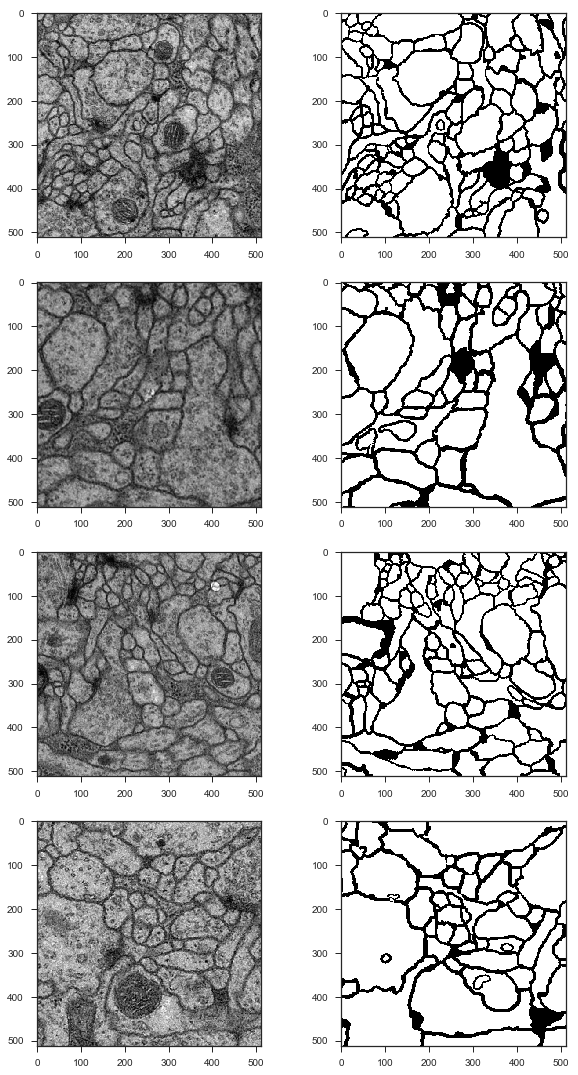

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 19))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [15]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import load_model

from Loss_Functions import cross_entropy_balanced
from U_Net import u_net_fuse_v1
from Loss_Functions import dice_coef, jaccard_coef, pixel_error

In [16]:
model_unet_side_fuse = u_net_fuse_v1(input_shape=(512, 512, 1))
model_unet_side_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 512, 512, 8)  80          lambda_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv_1a (C

In [9]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v1', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_side_fuse.compile(loss={'o1': cross_entropy_balanced,
                                'o2': cross_entropy_balanced,
                                'o3': cross_entropy_balanced,
                                'o4': cross_entropy_balanced,
                                'o5': cross_entropy_balanced,
                                'ofuse': cross_entropy_balanced,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_side_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=100, callbacks=callback_list, verbose=2)

Train on 189 samples, validate on 21 samples


Epoch 1/100


 - 27s - loss: 1.4346 - o1_loss: 0.2410 - o2_loss: 0.2410 - o3_loss: 0.2410 - o4_loss: 0.2371 - o5_loss: 0.2274 - ofuse_loss: 0.2471 - ofuse_dice_coef: 0.3066 - ofuse_jaccard_coef: 0.1804 - ofuse_pixel_error: 0.5290 - val_loss: 1.3754 - val_o1_loss: 0.2356 - val_o2_loss: 0.2357 - val_o3_loss: 0.2358 - val_o4_loss: 0.2220 - val_o5_loss: 0.1998 - val_ofuse_loss: 0.2464 - val_ofuse_dice_coef: 0.3073 - val_ofuse_jaccard_coef: 0.1808 - val_ofuse_pixel_error: 0.4962



Epoch 00001: val_loss improved from inf to 1.37539, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/100


 - 11s - loss: 1.3376 - o1_loss: 0.2407 - o2_loss: 0.2411 - o3_loss: 0.2411 - o4_loss: 0.2018 - o5_loss: 0.1809 - ofuse_loss: 0.2320 - ofuse_dice_coef: 0.3613 - ofuse_jaccard_coef: 0.2210 - ofuse_pixel_error: 0.3989 - val_loss: 1.2246 - val_o1_loss: 0.2345 - val_o2_loss: 0.2354 - val_o3_loss: 0.2358 - val_o4_loss: 0.1701 - val_o5_loss: 0.1479 - val_ofuse_loss: 0.2010 - val_ofuse_dice_coef: 0.4169 - val_ofuse_jaccard_coef: 0.2634 - val_ofuse_pixel_error: 0.3360



Epoch 00002: val_loss improved from 1.37539 to 1.22458, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/100


 - 11s - loss: 1.2193 - o1_loss: 0.2402 - o2_loss: 0.2407 - o3_loss: 0.2410 - o4_loss: 0.1638 - o5_loss: 0.1481 - ofuse_loss: 0.1853 - ofuse_dice_coef: 0.4583 - ofuse_jaccard_coef: 0.2981 - ofuse_pixel_error: 0.2862 - val_loss: 1.1417 - val_o1_loss: 0.2355 - val_o2_loss: 0.2358 - val_o3_loss: 0.2358 - val_o4_loss: 0.1428 - val_o5_loss: 0.1304 - val_ofuse_loss: 0.1616 - val_ofuse_dice_coef: 0.4863 - val_ofuse_jaccard_coef: 0.3206 - val_ofuse_pixel_error: 0.2571



Epoch 00003: val_loss improved from 1.22458 to 1.14175, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/100


 - 11s - loss: 1.1427 - o1_loss: 0.2406 - o2_loss: 0.2409 - o3_loss: 0.2410 - o4_loss: 0.1395 - o5_loss: 0.1278 - ofuse_loss: 0.1529 - ofuse_dice_coef: 0.5335 - ofuse_jaccard_coef: 0.3639 - ofuse_pixel_error: 0.2137 - val_loss: 1.1043 - val_o1_loss: 0.2334 - val_o2_loss: 0.2341 - val_o3_loss: 0.2358 - val_o4_loss: 0.1329 - val_o5_loss: 0.1258 - val_ofuse_loss: 0.1423 - val_ofuse_dice_coef: 0.5339 - val_ofuse_jaccard_coef: 0.3628 - val_ofuse_pixel_error: 0.2397



Epoch 00004: val_loss improved from 1.14175 to 1.10432, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/100


 - 11s - loss: 1.1063 - o1_loss: 0.2395 - o2_loss: 0.2402 - o3_loss: 0.2406 - o4_loss: 0.1282 - o5_loss: 0.1201 - ofuse_loss: 0.1376 - ofuse_dice_coef: 0.5699 - ofuse_jaccard_coef: 0.3978 - ofuse_pixel_error: 0.1904 - val_loss: 1.0578 - val_o1_loss: 0.2337 - val_o2_loss: 0.2346 - val_o3_loss: 0.2343 - val_o4_loss: 0.1182 - val_o5_loss: 0.1107 - val_ofuse_loss: 0.1264 - val_ofuse_dice_coef: 0.5891 - val_ofuse_jaccard_coef: 0.4159 - val_ofuse_pixel_error: 0.1595



Epoch 00005: val_loss improved from 1.10432 to 1.05777, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/100


 - 11s - loss: 1.0775 - o1_loss: 0.2391 - o2_loss: 0.2399 - o3_loss: 0.2391 - o4_loss: 0.1198 - o5_loss: 0.1133 - ofuse_loss: 0.1264 - ofuse_dice_coef: 0.5994 - ofuse_jaccard_coef: 0.4272 - ofuse_pixel_error: 0.1740 - val_loss: 1.0380 - val_o1_loss: 0.2331 - val_o2_loss: 0.2339 - val_o3_loss: 0.2342 - val_o4_loss: 0.1109 - val_o5_loss: 0.1076 - val_ofuse_loss: 0.1182 - val_ofuse_dice_coef: 0.5949 - val_ofuse_jaccard_coef: 0.4215 - val_ofuse_pixel_error: 0.1556



Epoch 00006: val_loss improved from 1.05777 to 1.03799, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 7/100


 - 11s - loss: 1.0560 - o1_loss: 0.2377 - o2_loss: 0.2385 - o3_loss: 0.2374 - o4_loss: 0.1141 - o5_loss: 0.1094 - ofuse_loss: 0.1188 - ofuse_dice_coef: 0.6192 - ofuse_jaccard_coef: 0.4472 - ofuse_pixel_error: 0.1604 - val_loss: 1.0075 - val_o1_loss: 0.2309 - val_o2_loss: 0.2308 - val_o3_loss: 0.2284 - val_o4_loss: 0.1048 - val_o5_loss: 0.1024 - val_ofuse_loss: 0.1101 - val_ofuse_dice_coef: 0.6223 - val_ofuse_jaccard_coef: 0.4488 - val_ofuse_pixel_error: 0.1455



Epoch 00007: val_loss improved from 1.03799 to 1.00749, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/100


 - 11s - loss: 1.0222 - o1_loss: 0.2346 - o2_loss: 0.2367 - o3_loss: 0.2186 - o4_loss: 0.1109 - o5_loss: 0.1071 - ofuse_loss: 0.1143 - ofuse_dice_coef: 0.6323 - ofuse_jaccard_coef: 0.4613 - ofuse_pixel_error: 0.1538 - val_loss: 0.9562 - val_o1_loss: 0.2248 - val_o2_loss: 0.2283 - val_o3_loss: 0.1808 - val_o4_loss: 0.1068 - val_o5_loss: 0.1046 - val_ofuse_loss: 0.1109 - val_ofuse_dice_coef: 0.6339 - val_ofuse_jaccard_coef: 0.4616 - val_ofuse_pixel_error: 0.1206



Epoch 00008: val_loss improved from 1.00749 to 0.95617, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 9/100


 - 11s - loss: 0.9448 - o1_loss: 0.2305 - o2_loss: 0.2293 - o3_loss: 0.1713 - o4_loss: 0.1054 - o5_loss: 0.1007 - ofuse_loss: 0.1076 - ofuse_dice_coef: 0.6530 - ofuse_jaccard_coef: 0.4839 - ofuse_pixel_error: 0.1398 - val_loss: 0.8635 - val_o1_loss: 0.2195 - val_o2_loss: 0.2168 - val_o3_loss: 0.1436 - val_o4_loss: 0.0952 - val_o5_loss: 0.0908 - val_ofuse_loss: 0.0975 - val_ofuse_dice_coef: 0.6642 - val_ofuse_jaccard_coef: 0.4945 - val_ofuse_pixel_error: 0.1258



Epoch 00009: val_loss improved from 0.95617 to 0.86345, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 10/100


 - 11s - loss: 0.8945 - o1_loss: 0.2242 - o2_loss: 0.2216 - o3_loss: 0.1500 - o4_loss: 0.1004 - o5_loss: 0.0967 - ofuse_loss: 0.1016 - ofuse_dice_coef: 0.6718 - ofuse_jaccard_coef: 0.5042 - ofuse_pixel_error: 0.1318 - val_loss: 0.8162 - val_o1_loss: 0.2145 - val_o2_loss: 0.2096 - val_o3_loss: 0.1261 - val_o4_loss: 0.0887 - val_o5_loss: 0.0863 - val_ofuse_loss: 0.0910 - val_ofuse_dice_coef: 0.6859 - val_ofuse_jaccard_coef: 0.5191 - val_ofuse_pixel_error: 0.1149



Epoch 00010: val_loss improved from 0.86345 to 0.81619, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 11/100


 - 11s - loss: 0.8360 - o1_loss: 0.2181 - o2_loss: 0.2142 - o3_loss: 0.1287 - o4_loss: 0.0924 - o5_loss: 0.0892 - ofuse_loss: 0.0934 - ofuse_dice_coef: 0.6960 - ofuse_jaccard_coef: 0.5328 - ofuse_pixel_error: 0.1215 - val_loss: 0.7707 - val_o1_loss: 0.2071 - val_o2_loss: 0.2020 - val_o3_loss: 0.1131 - val_o4_loss: 0.0831 - val_o5_loss: 0.0801 - val_ofuse_loss: 0.0853 - val_ofuse_dice_coef: 0.7023 - val_ofuse_jaccard_coef: 0.5388 - val_ofuse_pixel_error: 0.1208



Epoch 00011: val_loss improved from 0.81619 to 0.77068, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/100


 - 11s - loss: 0.7968 - o1_loss: 0.2125 - o2_loss: 0.2070 - o3_loss: 0.1170 - o4_loss: 0.0872 - o5_loss: 0.0846 - ofuse_loss: 0.0884 - ofuse_dice_coef: 0.7090 - ofuse_jaccard_coef: 0.5478 - ofuse_pixel_error: 0.1176 - val_loss: 0.7587 - val_o1_loss: 0.2044 - val_o2_loss: 0.1974 - val_o3_loss: 0.1078 - val_o4_loss: 0.0829 - val_o5_loss: 0.0808 - val_ofuse_loss: 0.0854 - val_ofuse_dice_coef: 0.7173 - val_ofuse_jaccard_coef: 0.5566 - val_ofuse_pixel_error: 0.1002



Epoch 00012: val_loss improved from 0.77068 to 0.75869, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 13/100


 - 11s - loss: 0.7683 - o1_loss: 0.2076 - o2_loss: 0.2000 - o3_loss: 0.1101 - o4_loss: 0.0839 - o5_loss: 0.0817 - ofuse_loss: 0.0851 - ofuse_dice_coef: 0.7222 - ofuse_jaccard_coef: 0.5642 - ofuse_pixel_error: 0.1131 - val_loss: 0.7251 - val_o1_loss: 0.2004 - val_o2_loss: 0.1908 - val_o3_loss: 0.1022 - val_o4_loss: 0.0771 - val_o5_loss: 0.0754 - val_ofuse_loss: 0.0793 - val_ofuse_dice_coef: 0.7259 - val_ofuse_jaccard_coef: 0.5673 - val_ofuse_pixel_error: 0.1056



Epoch 00013: val_loss improved from 0.75869 to 0.72515, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 14/100


 - 11s - loss: 0.7387 - o1_loss: 0.2032 - o2_loss: 0.1933 - o3_loss: 0.1036 - o4_loss: 0.0799 - o5_loss: 0.0779 - ofuse_loss: 0.0808 - ofuse_dice_coef: 0.7339 - ofuse_jaccard_coef: 0.5787 - ofuse_pixel_error: 0.1086 - val_loss: 0.7020 - val_o1_loss: 0.1966 - val_o2_loss: 0.1835 - val_o3_loss: 0.0963 - val_o4_loss: 0.0755 - val_o5_loss: 0.0736 - val_ofuse_loss: 0.0765 - val_ofuse_dice_coef: 0.7396 - val_ofuse_jaccard_coef: 0.5844 - val_ofuse_pixel_error: 0.1021



Epoch 00014: val_loss improved from 0.72515 to 0.70202, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 15/100


 - 11s - loss: 0.7152 - o1_loss: 0.1996 - o2_loss: 0.1875 - o3_loss: 0.0986 - o4_loss: 0.0768 - o5_loss: 0.0750 - ofuse_loss: 0.0776 - ofuse_dice_coef: 0.7442 - ofuse_jaccard_coef: 0.5917 - ofuse_pixel_error: 0.1052 - val_loss: 0.6897 - val_o1_loss: 0.1941 - val_o2_loss: 0.1795 - val_o3_loss: 0.0947 - val_o4_loss: 0.0746 - val_o5_loss: 0.0719 - val_ofuse_loss: 0.0748 - val_ofuse_dice_coef: 0.7529 - val_ofuse_jaccard_coef: 0.6011 - val_ofuse_pixel_error: 0.0933



Epoch 00015: val_loss improved from 0.70202 to 0.68967, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 16/100


 - 11s - loss: 0.6929 - o1_loss: 0.1963 - o2_loss: 0.1817 - o3_loss: 0.0942 - o4_loss: 0.0739 - o5_loss: 0.0723 - ofuse_loss: 0.0747 - ofuse_dice_coef: 0.7518 - ofuse_jaccard_coef: 0.6010 - ofuse_pixel_error: 0.1026 - val_loss: 0.6867 - val_o1_loss: 0.1917 - val_o2_loss: 0.1757 - val_o3_loss: 0.0923 - val_o4_loss: 0.0758 - val_o5_loss: 0.0744 - val_ofuse_loss: 0.0767 - val_ofuse_dice_coef: 0.7566 - val_ofuse_jaccard_coef: 0.6062 - val_ofuse_pixel_error: 0.0913



Epoch 00016: val_loss improved from 0.68967 to 0.68667, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 17/100


 - 11s - loss: 0.6737 - o1_loss: 0.1931 - o2_loss: 0.1753 - o3_loss: 0.0910 - o4_loss: 0.0717 - o5_loss: 0.0703 - ofuse_loss: 0.0723 - ofuse_dice_coef: 0.7607 - ofuse_jaccard_coef: 0.6127 - ofuse_pixel_error: 0.0991 - val_loss: 0.6626 - val_o1_loss: 0.1902 - val_o2_loss: 0.1713 - val_o3_loss: 0.0887 - val_o4_loss: 0.0711 - val_o5_loss: 0.0694 - val_ofuse_loss: 0.0719 - val_ofuse_dice_coef: 0.7566 - val_ofuse_jaccard_coef: 0.6061 - val_ofuse_pixel_error: 0.0978



Epoch 00017: val_loss improved from 0.68667 to 0.66260, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 18/100


 - 11s - loss: 0.6560 - o1_loss: 0.1908 - o2_loss: 0.1709 - o3_loss: 0.0875 - o4_loss: 0.0692 - o5_loss: 0.0678 - ofuse_loss: 0.0698 - ofuse_dice_coef: 0.7678 - ofuse_jaccard_coef: 0.6219 - ofuse_pixel_error: 0.0965 - val_loss: 0.6585 - val_o1_loss: 0.1895 - val_o2_loss: 0.1690 - val_o3_loss: 0.0873 - val_o4_loss: 0.0708 - val_o5_loss: 0.0694 - val_ofuse_loss: 0.0723 - val_ofuse_dice_coef: 0.7600 - val_ofuse_jaccard_coef: 0.6105 - val_ofuse_pixel_error: 0.1005



Epoch 00018: val_loss improved from 0.66260 to 0.65846, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 19/100


 - 11s - loss: 0.6384 - o1_loss: 0.1881 - o2_loss: 0.1656 - o3_loss: 0.0844 - o4_loss: 0.0670 - o5_loss: 0.0657 - ofuse_loss: 0.0676 - ofuse_dice_coef: 0.7742 - ofuse_jaccard_coef: 0.6303 - ofuse_pixel_error: 0.0942 - val_loss: 0.6696 - val_o1_loss: 0.1877 - val_o2_loss: 0.1682 - val_o3_loss: 0.0889 - val_o4_loss: 0.0754 - val_o5_loss: 0.0735 - val_ofuse_loss: 0.0759 - val_ofuse_dice_coef: 0.7668 - val_ofuse_jaccard_coef: 0.6194 - val_ofuse_pixel_error: 0.0873



Epoch 00019: val_loss did not improve
Epoch 20/100


 - 10s - loss: 0.6267 - o1_loss: 0.1861 - o2_loss: 0.1614 - o3_loss: 0.0825 - o4_loss: 0.0658 - o5_loss: 0.0646 - ofuse_loss: 0.0663 - ofuse_dice_coef: 0.7790 - ofuse_jaccard_coef: 0.6370 - ofuse_pixel_error: 0.0917 - val_loss: 0.6689 - val_o1_loss: 0.1877 - val_o2_loss: 0.1650 - val_o3_loss: 0.0892 - val_o4_loss: 0.0762 - val_o5_loss: 0.0745 - val_ofuse_loss: 0.0762 - val_ofuse_dice_coef: 0.7700 - val_ofuse_jaccard_coef: 0.6234 - val_ofuse_pixel_error: 0.0844



Epoch 00020: val_loss did not improve
Epoch 21/100


 - 11s - loss: 0.6158 - o1_loss: 0.1844 - o2_loss: 0.1583 - o3_loss: 0.0805 - o4_loss: 0.0644 - o5_loss: 0.0633 - ofuse_loss: 0.0648 - ofuse_dice_coef: 0.7839 - ofuse_jaccard_coef: 0.6436 - ofuse_pixel_error: 0.0897 - val_loss: 0.6593 - val_o1_loss: 0.1863 - val_o2_loss: 0.1639 - val_o3_loss: 0.0873 - val_o4_loss: 0.0742 - val_o5_loss: 0.0725 - val_ofuse_loss: 0.0751 - val_ofuse_dice_coef: 0.7736 - val_ofuse_jaccard_coef: 0.6284 - val_ofuse_pixel_error: 0.0896



Epoch 00021: val_loss did not improve
Epoch 22/100


 - 11s - loss: 0.5981 - o1_loss: 0.1823 - o2_loss: 0.1538 - o3_loss: 0.0774 - o4_loss: 0.0617 - o5_loss: 0.0606 - ofuse_loss: 0.0622 - ofuse_dice_coef: 0.7916 - ofuse_jaccard_coef: 0.6541 - ofuse_pixel_error: 0.0862 - val_loss: 0.6528 - val_o1_loss: 0.1851 - val_o2_loss: 0.1617 - val_o3_loss: 0.0866 - val_o4_loss: 0.0731 - val_o5_loss: 0.0723 - val_ofuse_loss: 0.0740 - val_ofuse_dice_coef: 0.7747 - val_ofuse_jaccard_coef: 0.6297 - val_ofuse_pixel_error: 0.0939



Epoch 00022: val_loss improved from 0.65846 to 0.65278, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 23/100


 - 11s - loss: 0.5868 - o1_loss: 0.1810 - o2_loss: 0.1503 - o3_loss: 0.0752 - o4_loss: 0.0603 - o5_loss: 0.0593 - ofuse_loss: 0.0608 - ofuse_dice_coef: 0.7964 - ofuse_jaccard_coef: 0.6605 - ofuse_pixel_error: 0.0846 - val_loss: 0.6779 - val_o1_loss: 0.1848 - val_o2_loss: 0.1616 - val_o3_loss: 0.0942 - val_o4_loss: 0.0798 - val_o5_loss: 0.0779 - val_ofuse_loss: 0.0797 - val_ofuse_dice_coef: 0.7836 - val_ofuse_jaccard_coef: 0.6414 - val_ofuse_pixel_error: 0.0838



Epoch 00023: val_loss did not improve
Epoch 24/100


 - 10s - loss: 0.5775 - o1_loss: 0.1797 - o2_loss: 0.1473 - o3_loss: 0.0739 - o4_loss: 0.0590 - o5_loss: 0.0580 - ofuse_loss: 0.0594 - ofuse_dice_coef: 0.8005 - ofuse_jaccard_coef: 0.6664 - ofuse_pixel_error: 0.0825 - val_loss: 0.6745 - val_o1_loss: 0.1846 - val_o2_loss: 0.1601 - val_o3_loss: 0.0905 - val_o4_loss: 0.0801 - val_o5_loss: 0.0786 - val_ofuse_loss: 0.0806 - val_ofuse_dice_coef: 0.7846 - val_ofuse_jaccard_coef: 0.6429 - val_ofuse_pixel_error: 0.0834



Epoch 00024: val_loss did not improve
Epoch 25/100


 - 10s - loss: 0.5670 - o1_loss: 0.1787 - o2_loss: 0.1446 - o3_loss: 0.0718 - o4_loss: 0.0575 - o5_loss: 0.0565 - ofuse_loss: 0.0579 - ofuse_dice_coef: 0.8056 - ofuse_jaccard_coef: 0.6734 - ofuse_pixel_error: 0.0801 - val_loss: 0.6738 - val_o1_loss: 0.1841 - val_o2_loss: 0.1595 - val_o3_loss: 0.0912 - val_o4_loss: 0.0799 - val_o5_loss: 0.0789 - val_ofuse_loss: 0.0803 - val_ofuse_dice_coef: 0.7863 - val_ofuse_jaccard_coef: 0.6450 - val_ofuse_pixel_error: 0.0872



Epoch 00025: val_loss did not improve
Epoch 26/100


 - 11s - loss: 0.5591 - o1_loss: 0.1778 - o2_loss: 0.1422 - o3_loss: 0.0705 - o4_loss: 0.0563 - o5_loss: 0.0555 - ofuse_loss: 0.0568 - ofuse_dice_coef: 0.8090 - ofuse_jaccard_coef: 0.6783 - ofuse_pixel_error: 0.0787 - val_loss: 0.6768 - val_o1_loss: 0.1832 - val_o2_loss: 0.1583 - val_o3_loss: 0.0916 - val_o4_loss: 0.0811 - val_o5_loss: 0.0808 - val_ofuse_loss: 0.0817 - val_ofuse_dice_coef: 0.7878 - val_ofuse_jaccard_coef: 0.6472 - val_ofuse_pixel_error: 0.0867



Epoch 00026: val_loss did not improve
Epoch 27/100


 - 11s - loss: 0.5538 - o1_loss: 0.1773 - o2_loss: 0.1406 - o3_loss: 0.0696 - o4_loss: 0.0556 - o5_loss: 0.0548 - ofuse_loss: 0.0560 - ofuse_dice_coef: 0.8116 - ofuse_jaccard_coef: 0.6821 - ofuse_pixel_error: 0.0774 - val_loss: 0.6850 - val_o1_loss: 0.1837 - val_o2_loss: 0.1609 - val_o3_loss: 0.0936 - val_o4_loss: 0.0823 - val_o5_loss: 0.0817 - val_ofuse_loss: 0.0828 - val_ofuse_dice_coef: 0.7877 - val_ofuse_jaccard_coef: 0.6471 - val_ofuse_pixel_error: 0.0833



Epoch 00027: val_loss did not improve
Epoch 28/100


 - 11s - loss: 0.5494 - o1_loss: 0.1767 - o2_loss: 0.1387 - o3_loss: 0.0691 - o4_loss: 0.0551 - o5_loss: 0.0544 - ofuse_loss: 0.0554 - ofuse_dice_coef: 0.8137 - ofuse_jaccard_coef: 0.6849 - ofuse_pixel_error: 0.0763 - val_loss: 0.6830 - val_o1_loss: 0.1836 - val_o2_loss: 0.1607 - val_o3_loss: 0.0928 - val_o4_loss: 0.0817 - val_o5_loss: 0.0813 - val_ofuse_loss: 0.0829 - val_ofuse_dice_coef: 0.7909 - val_ofuse_jaccard_coef: 0.6515 - val_ofuse_pixel_error: 0.0859



Epoch 00028: val_loss did not improve
Epoch 29/100


 - 10s - loss: 0.5375 - o1_loss: 0.1759 - o2_loss: 0.1365 - o3_loss: 0.0667 - o4_loss: 0.0529 - o5_loss: 0.0522 - ofuse_loss: 0.0533 - ofuse_dice_coef: 0.8202 - ofuse_jaccard_coef: 0.6941 - ofuse_pixel_error: 0.0736 - val_loss: 0.6605 - val_o1_loss: 0.1831 - val_o2_loss: 0.1569 - val_o3_loss: 0.0889 - val_o4_loss: 0.0769 - val_o5_loss: 0.0767 - val_ofuse_loss: 0.0780 - val_ofuse_dice_coef: 0.7830 - val_ofuse_jaccard_coef: 0.6408 - val_ofuse_pixel_error: 0.0927



Epoch 00029: val_loss did not improve
Epoch 30/100


 - 10s - loss: 0.5274 - o1_loss: 0.1751 - o2_loss: 0.1339 - o3_loss: 0.0648 - o4_loss: 0.0513 - o5_loss: 0.0506 - ofuse_loss: 0.0517 - ofuse_dice_coef: 0.8251 - ofuse_jaccard_coef: 0.7012 - ofuse_pixel_error: 0.0713 - val_loss: 0.6794 - val_o1_loss: 0.1847 - val_o2_loss: 0.1603 - val_o3_loss: 0.0925 - val_o4_loss: 0.0800 - val_o5_loss: 0.0805 - val_ofuse_loss: 0.0814 - val_ofuse_dice_coef: 0.7871 - val_ofuse_jaccard_coef: 0.6464 - val_ofuse_pixel_error: 0.0923



Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00030: val_loss did not improve
Epoch 31/100


 - 10s - loss: 0.5192 - o1_loss: 0.1742 - o2_loss: 0.1316 - o3_loss: 0.0634 - o4_loss: 0.0501 - o5_loss: 0.0494 - ofuse_loss: 0.0504 - ofuse_dice_coef: 0.8296 - ofuse_jaccard_coef: 0.7080 - ofuse_pixel_error: 0.0694 - val_loss: 0.7234 - val_o1_loss: 0.1838 - val_o2_loss: 0.1613 - val_o3_loss: 0.1013 - val_o4_loss: 0.0918 - val_o5_loss: 0.0925 - val_ofuse_loss: 0.0927 - val_ofuse_dice_coef: 0.7934 - val_ofuse_jaccard_coef: 0.6545 - val_ofuse_pixel_error: 0.0821



Epoch 00031: val_loss did not improve
Epoch 32/100


 - 10s - loss: 0.5076 - o1_loss: 0.1735 - o2_loss: 0.1291 - o3_loss: 0.0613 - o4_loss: 0.0480 - o5_loss: 0.0474 - ofuse_loss: 0.0484 - ofuse_dice_coef: 0.8361 - ofuse_jaccard_coef: 0.7174 - ofuse_pixel_error: 0.0665 - val_loss: 0.7144 - val_o1_loss: 0.1833 - val_o2_loss: 0.1603 - val_o3_loss: 0.0995 - val_o4_loss: 0.0900 - val_o5_loss: 0.0902 - val_ofuse_loss: 0.0911 - val_ofuse_dice_coef: 0.7934 - val_ofuse_jaccard_coef: 0.6548 - val_ofuse_pixel_error: 0.0848



Epoch 00032: val_loss did not improve
Epoch 33/100


 - 10s - loss: 0.5012 - o1_loss: 0.1729 - o2_loss: 0.1274 - o3_loss: 0.0603 - o4_loss: 0.0470 - o5_loss: 0.0463 - ofuse_loss: 0.0473 - ofuse_dice_coef: 0.8396 - ofuse_jaccard_coef: 0.7229 - ofuse_pixel_error: 0.0649 - val_loss: 0.7303 - val_o1_loss: 0.1845 - val_o2_loss: 0.1603 - val_o3_loss: 0.1009 - val_o4_loss: 0.0940 - val_o5_loss: 0.0951 - val_ofuse_loss: 0.0955 - val_ofuse_dice_coef: 0.7925 - val_ofuse_jaccard_coef: 0.6536 - val_ofuse_pixel_error: 0.0863



Epoch 00033: val_loss did not improve
Epoch 34/100


 - 10s - loss: 0.4977 - o1_loss: 0.1726 - o2_loss: 0.1265 - o3_loss: 0.0596 - o4_loss: 0.0464 - o5_loss: 0.0458 - ofuse_loss: 0.0467 - ofuse_dice_coef: 0.8412 - ofuse_jaccard_coef: 0.7251 - ofuse_pixel_error: 0.0643 - val_loss: 0.7534 - val_o1_loss: 0.1837 - val_o2_loss: 0.1633 - val_o3_loss: 0.1074 - val_o4_loss: 0.0989 - val_o5_loss: 0.1000 - val_ofuse_loss: 0.1001 - val_ofuse_dice_coef: 0.7949 - val_ofuse_jaccard_coef: 0.6568 - val_ofuse_pixel_error: 0.0815



Epoch 00034: val_loss did not improve
Epoch 35/100


 - 11s - loss: 0.4940 - o1_loss: 0.1725 - o2_loss: 0.1258 - o3_loss: 0.0591 - o4_loss: 0.0456 - o5_loss: 0.0450 - ofuse_loss: 0.0459 - ofuse_dice_coef: 0.8439 - ofuse_jaccard_coef: 0.7292 - ofuse_pixel_error: 0.0627 - val_loss: 0.7596 - val_o1_loss: 0.1854 - val_o2_loss: 0.1635 - val_o3_loss: 0.1060 - val_o4_loss: 0.1004 - val_o5_loss: 0.1019 - val_ofuse_loss: 0.1024 - val_ofuse_dice_coef: 0.7963 - val_ofuse_jaccard_coef: 0.6590 - val_ofuse_pixel_error: 0.0833



Epoch 00035: val_loss did not improve
Epoch 36/100


 - 10s - loss: 0.4898 - o1_loss: 0.1723 - o2_loss: 0.1249 - o3_loss: 0.0582 - o4_loss: 0.0449 - o5_loss: 0.0443 - ofuse_loss: 0.0452 - ofuse_dice_coef: 0.8465 - ofuse_jaccard_coef: 0.7329 - ofuse_pixel_error: 0.0619 - val_loss: 0.7554 - val_o1_loss: 0.1840 - val_o2_loss: 0.1621 - val_o3_loss: 0.1051 - val_o4_loss: 0.1003 - val_o5_loss: 0.1017 - val_ofuse_loss: 0.1022 - val_ofuse_dice_coef: 0.7960 - val_ofuse_jaccard_coef: 0.6584 - val_ofuse_pixel_error: 0.0832



Epoch 00036: val_loss did not improve
Epoch 37/100


 - 10s - loss: 0.4871 - o1_loss: 0.1721 - o2_loss: 0.1241 - o3_loss: 0.0578 - o4_loss: 0.0445 - o5_loss: 0.0439 - ofuse_loss: 0.0447 - ofuse_dice_coef: 0.8477 - ofuse_jaccard_coef: 0.7350 - ofuse_pixel_error: 0.0612 - val_loss: 0.7668 - val_o1_loss: 0.1846 - val_o2_loss: 0.1627 - val_o3_loss: 0.1080 - val_o4_loss: 0.1026 - val_o5_loss: 0.1044 - val_ofuse_loss: 0.1045 - val_ofuse_dice_coef: 0.7958 - val_ofuse_jaccard_coef: 0.6580 - val_ofuse_pixel_error: 0.0819



Epoch 00037: val_loss did not improve
Epoch 38/100


 - 10s - loss: 0.4829 - o1_loss: 0.1719 - o2_loss: 0.1235 - o3_loss: 0.0571 - o4_loss: 0.0435 - o5_loss: 0.0430 - ofuse_loss: 0.0438 - ofuse_dice_coef: 0.8507 - ofuse_jaccard_coef: 0.7396 - ofuse_pixel_error: 0.0598 - val_loss: 0.7604 - val_o1_loss: 0.1849 - val_o2_loss: 0.1640 - val_o3_loss: 0.1063 - val_o4_loss: 0.1004 - val_o5_loss: 0.1023 - val_ofuse_loss: 0.1024 - val_ofuse_dice_coef: 0.7974 - val_ofuse_jaccard_coef: 0.6604 - val_ofuse_pixel_error: 0.0841



Epoch 00038: val_loss did not improve
Epoch 39/100


 - 10s - loss: 0.4770 - o1_loss: 0.1716 - o2_loss: 0.1223 - o3_loss: 0.0560 - o4_loss: 0.0425 - o5_loss: 0.0419 - ofuse_loss: 0.0427 - ofuse_dice_coef: 0.8544 - ofuse_jaccard_coef: 0.7453 - ofuse_pixel_error: 0.0582 - val_loss: 0.7647 - val_o1_loss: 0.1844 - val_o2_loss: 0.1632 - val_o3_loss: 0.1077 - val_o4_loss: 0.1019 - val_o5_loss: 0.1037 - val_ofuse_loss: 0.1037 - val_ofuse_dice_coef: 0.7954 - val_ofuse_jaccard_coef: 0.6574 - val_ofuse_pixel_error: 0.0833



Epoch 00039: val_loss did not improve
Epoch 40/100


 - 10s - loss: 0.4738 - o1_loss: 0.1714 - o2_loss: 0.1215 - o3_loss: 0.0555 - o4_loss: 0.0419 - o5_loss: 0.0414 - ofuse_loss: 0.0421 - ofuse_dice_coef: 0.8562 - ofuse_jaccard_coef: 0.7479 - ofuse_pixel_error: 0.0574 - val_loss: 0.7732 - val_o1_loss: 0.1846 - val_o2_loss: 0.1660 - val_o3_loss: 0.1105 - val_o4_loss: 0.1028 - val_o5_loss: 0.1041 - val_ofuse_loss: 0.1051 - val_ofuse_dice_coef: 0.7939 - val_ofuse_jaccard_coef: 0.6555 - val_ofuse_pixel_error: 0.0888



Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00040: val_loss did not improve
Epoch 41/100


 - 10s - loss: 0.4709 - o1_loss: 0.1712 - o2_loss: 0.1207 - o3_loss: 0.0551 - o4_loss: 0.0414 - o5_loss: 0.0409 - ofuse_loss: 0.0416 - ofuse_dice_coef: 0.8575 - ofuse_jaccard_coef: 0.7498 - ofuse_pixel_error: 0.0568 - val_loss: 0.7730 - val_o1_loss: 0.1851 - val_o2_loss: 0.1626 - val_o3_loss: 0.1094 - val_o4_loss: 0.1039 - val_o5_loss: 0.1058 - val_ofuse_loss: 0.1061 - val_ofuse_dice_coef: 0.7984 - val_ofuse_jaccard_coef: 0.6619 - val_ofuse_pixel_error: 0.0834



Epoch 00041: val_loss did not improve
Epoch 42/100


 - 10s - loss: 0.4621 - o1_loss: 0.1707 - o2_loss: 0.1191 - o3_loss: 0.0535 - o4_loss: 0.0397 - o5_loss: 0.0392 - ofuse_loss: 0.0399 - ofuse_dice_coef: 0.8631 - ofuse_jaccard_coef: 0.7586 - ofuse_pixel_error: 0.0543 - val_loss: 0.8395 - val_o1_loss: 0.1862 - val_o2_loss: 0.1677 - val_o3_loss: 0.1210 - val_o4_loss: 0.1195 - val_o5_loss: 0.1228 - val_ofuse_loss: 0.1222 - val_ofuse_dice_coef: 0.7972 - val_ofuse_jaccard_coef: 0.6598 - val_ofuse_pixel_error: 0.0813



Epoch 00042: val_loss did not improve
Epoch 43/100


 - 10s - loss: 0.4592 - o1_loss: 0.1705 - o2_loss: 0.1185 - o3_loss: 0.0531 - o4_loss: 0.0391 - o5_loss: 0.0386 - ofuse_loss: 0.0393 - ofuse_dice_coef: 0.8655 - ofuse_jaccard_coef: 0.7623 - ofuse_pixel_error: 0.0533 - val_loss: 0.8338 - val_o1_loss: 0.1851 - val_o2_loss: 0.1656 - val_o3_loss: 0.1187 - val_o4_loss: 0.1193 - val_o5_loss: 0.1229 - val_ofuse_loss: 0.1221 - val_ofuse_dice_coef: 0.7988 - val_ofuse_jaccard_coef: 0.6621 - val_ofuse_pixel_error: 0.0820



Epoch 00043: val_loss did not improve
Epoch 44/100


 - 10s - loss: 0.4539 - o1_loss: 0.1703 - o2_loss: 0.1176 - o3_loss: 0.0521 - o4_loss: 0.0380 - o5_loss: 0.0375 - ofuse_loss: 0.0383 - ofuse_dice_coef: 0.8687 - ofuse_jaccard_coef: 0.7674 - ofuse_pixel_error: 0.0517 - val_loss: 0.8112 - val_o1_loss: 0.1859 - val_o2_loss: 0.1647 - val_o3_loss: 0.1138 - val_o4_loss: 0.1136 - val_o5_loss: 0.1166 - val_ofuse_loss: 0.1166 - val_ofuse_dice_coef: 0.7983 - val_ofuse_jaccard_coef: 0.6615 - val_ofuse_pixel_error: 0.0847



Epoch 00044: val_loss did not improve
Epoch 45/100


 - 10s - loss: 0.4503 - o1_loss: 0.1701 - o2_loss: 0.1171 - o3_loss: 0.0515 - o4_loss: 0.0373 - o5_loss: 0.0368 - ofuse_loss: 0.0375 - ofuse_dice_coef: 0.8712 - ofuse_jaccard_coef: 0.7712 - ofuse_pixel_error: 0.0508 - val_loss: 0.8038 - val_o1_loss: 0.1862 - val_o2_loss: 0.1667 - val_o3_loss: 0.1120 - val_o4_loss: 0.1110 - val_o5_loss: 0.1138 - val_ofuse_loss: 0.1141 - val_ofuse_dice_coef: 0.7994 - val_ofuse_jaccard_coef: 0.6632 - val_ofuse_pixel_error: 0.0843



Epoch 00045: val_loss did not improve
Epoch 46/100


 - 10s - loss: 0.4474 - o1_loss: 0.1699 - o2_loss: 0.1165 - o3_loss: 0.0510 - o4_loss: 0.0367 - o5_loss: 0.0362 - ofuse_loss: 0.0370 - ofuse_dice_coef: 0.8728 - ofuse_jaccard_coef: 0.7738 - ofuse_pixel_error: 0.0501 - val_loss: 0.8523 - val_o1_loss: 0.1865 - val_o2_loss: 0.1674 - val_o3_loss: 0.1201 - val_o4_loss: 0.1235 - val_o5_loss: 0.1278 - val_ofuse_loss: 0.1270 - val_ofuse_dice_coef: 0.7998 - val_ofuse_jaccard_coef: 0.6636 - val_ofuse_pixel_error: 0.0833



Epoch 00046: val_loss did not improve
Epoch 47/100


 - 10s - loss: 0.4452 - o1_loss: 0.1698 - o2_loss: 0.1161 - o3_loss: 0.0507 - o4_loss: 0.0363 - o5_loss: 0.0358 - ofuse_loss: 0.0365 - ofuse_dice_coef: 0.8748 - ofuse_jaccard_coef: 0.7770 - ofuse_pixel_error: 0.0492 - val_loss: 0.8385 - val_o1_loss: 0.1871 - val_o2_loss: 0.1649 - val_o3_loss: 0.1173 - val_o4_loss: 0.1203 - val_o5_loss: 0.1251 - val_ofuse_loss: 0.1238 - val_ofuse_dice_coef: 0.7995 - val_ofuse_jaccard_coef: 0.6633 - val_ofuse_pixel_error: 0.0841



Epoch 00047: val_loss did not improve
Epoch 48/100


 - 10s - loss: 0.4469 - o1_loss: 0.1699 - o2_loss: 0.1161 - o3_loss: 0.0510 - o4_loss: 0.0367 - o5_loss: 0.0363 - ofuse_loss: 0.0369 - ofuse_dice_coef: 0.8735 - ofuse_jaccard_coef: 0.7748 - ofuse_pixel_error: 0.0498 - val_loss: 0.8099 - val_o1_loss: 0.1861 - val_o2_loss: 0.1626 - val_o3_loss: 0.1144 - val_o4_loss: 0.1136 - val_o5_loss: 0.1164 - val_ofuse_loss: 0.1168 - val_ofuse_dice_coef: 0.7977 - val_ofuse_jaccard_coef: 0.6608 - val_ofuse_pixel_error: 0.0863



Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00048: val_loss did not improve
Epoch 49/100


 - 10s - loss: 0.4501 - o1_loss: 0.1699 - o2_loss: 0.1164 - o3_loss: 0.0517 - o4_loss: 0.0374 - o5_loss: 0.0371 - ofuse_loss: 0.0376 - ofuse_dice_coef: 0.8711 - ofuse_jaccard_coef: 0.7711 - ofuse_pixel_error: 0.0511 - val_loss: 0.8893 - val_o1_loss: 0.1870 - val_o2_loss: 0.1690 - val_o3_loss: 0.1288 - val_o4_loss: 0.1318 - val_o5_loss: 0.1373 - val_ofuse_loss: 0.1352 - val_ofuse_dice_coef: 0.7972 - val_ofuse_jaccard_coef: 0.6598 - val_ofuse_pixel_error: 0.0821



Epoch 00049: val_loss did not improve
Epoch 50/100


 - 10s - loss: 0.4414 - o1_loss: 0.1697 - o2_loss: 0.1153 - o3_loss: 0.0501 - o4_loss: 0.0355 - o5_loss: 0.0351 - ofuse_loss: 0.0357 - ofuse_dice_coef: 0.8772 - ofuse_jaccard_coef: 0.7806 - ofuse_pixel_error: 0.0480 - val_loss: 0.8705 - val_o1_loss: 0.1863 - val_o2_loss: 0.1698 - val_o3_loss: 0.1231 - val_o4_loss: 0.1274 - val_o5_loss: 0.1328 - val_ofuse_loss: 0.1311 - val_ofuse_dice_coef: 0.8004 - val_ofuse_jaccard_coef: 0.6646 - val_ofuse_pixel_error: 0.0826



Epoch 00050: val_loss did not improve
Epoch 51/100


 - 10s - loss: 0.4352 - o1_loss: 0.1693 - o2_loss: 0.1142 - o3_loss: 0.0491 - o4_loss: 0.0343 - o5_loss: 0.0338 - ofuse_loss: 0.0345 - ofuse_dice_coef: 0.8812 - ofuse_jaccard_coef: 0.7871 - ofuse_pixel_error: 0.0463 - val_loss: 0.8723 - val_o1_loss: 0.1869 - val_o2_loss: 0.1676 - val_o3_loss: 0.1237 - val_o4_loss: 0.1284 - val_o5_loss: 0.1334 - val_ofuse_loss: 0.1323 - val_ofuse_dice_coef: 0.8000 - val_ofuse_jaccard_coef: 0.6641 - val_ofuse_pixel_error: 0.0844



Epoch 00051: val_loss did not improve
Epoch 52/100


 - 10s - loss: 0.4313 - o1_loss: 0.1691 - o2_loss: 0.1136 - o3_loss: 0.0484 - o4_loss: 0.0335 - o5_loss: 0.0330 - ofuse_loss: 0.0337 - ofuse_dice_coef: 0.8839 - ofuse_jaccard_coef: 0.7914 - ofuse_pixel_error: 0.0453 - val_loss: 0.9199 - val_o1_loss: 0.1869 - val_o2_loss: 0.1715 - val_o3_loss: 0.1307 - val_o4_loss: 0.1399 - val_o5_loss: 0.1466 - val_ofuse_loss: 0.1445 - val_ofuse_dice_coef: 0.7988 - val_ofuse_jaccard_coef: 0.6622 - val_ofuse_pixel_error: 0.0830



Epoch 00052: val_loss did not improve
Epoch 53/100


 - 10s - loss: 0.4299 - o1_loss: 0.1691 - o2_loss: 0.1132 - o3_loss: 0.0482 - o4_loss: 0.0332 - o5_loss: 0.0327 - ofuse_loss: 0.0334 - ofuse_dice_coef: 0.8849 - ofuse_jaccard_coef: 0.7930 - ofuse_pixel_error: 0.0447 - val_loss: 0.8889 - val_o1_loss: 0.1873 - val_o2_loss: 0.1713 - val_o3_loss: 0.1253 - val_o4_loss: 0.1317 - val_o5_loss: 0.1370 - val_ofuse_loss: 0.1363 - val_ofuse_dice_coef: 0.7999 - val_ofuse_jaccard_coef: 0.6638 - val_ofuse_pixel_error: 0.0855



Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00053: val_loss did not improve
Epoch 54/100


 - 10s - loss: 0.4269 - o1_loss: 0.1689 - o2_loss: 0.1128 - o3_loss: 0.0477 - o4_loss: 0.0326 - o5_loss: 0.0321 - ofuse_loss: 0.0328 - ofuse_dice_coef: 0.8867 - ofuse_jaccard_coef: 0.7960 - ofuse_pixel_error: 0.0440 - val_loss: 0.9345 - val_o1_loss: 0.1870 - val_o2_loss: 0.1714 - val_o3_loss: 0.1319 - val_o4_loss: 0.1441 - val_o5_loss: 0.1511 - val_ofuse_loss: 0.1490 - val_ofuse_dice_coef: 0.8000 - val_ofuse_jaccard_coef: 0.6639 - val_ofuse_pixel_error: 0.0843



Epoch 00054: val_loss did not improve
Epoch 55/100


 - 10s - loss: 0.4225 - o1_loss: 0.1687 - o2_loss: 0.1120 - o3_loss: 0.0470 - o4_loss: 0.0317 - o5_loss: 0.0312 - ofuse_loss: 0.0319 - ofuse_dice_coef: 0.8897 - ofuse_jaccard_coef: 0.8010 - ofuse_pixel_error: 0.0427 - val_loss: 0.9267 - val_o1_loss: 0.1876 - val_o2_loss: 0.1713 - val_o3_loss: 0.1289 - val_o4_loss: 0.1422 - val_o5_loss: 0.1495 - val_ofuse_loss: 0.1473 - val_ofuse_dice_coef: 0.7994 - val_ofuse_jaccard_coef: 0.6632 - val_ofuse_pixel_error: 0.0853



Epoch 00055: val_loss did not improve
Epoch 56/100


 - 10s - loss: 0.4202 - o1_loss: 0.1686 - o2_loss: 0.1117 - o3_loss: 0.0467 - o4_loss: 0.0311 - o5_loss: 0.0306 - ofuse_loss: 0.0313 - ofuse_dice_coef: 0.8915 - ofuse_jaccard_coef: 0.8038 - ofuse_pixel_error: 0.0419 - val_loss: 0.9572 - val_o1_loss: 0.1881 - val_o2_loss: 0.1743 - val_o3_loss: 0.1333 - val_o4_loss: 0.1491 - val_o5_loss: 0.1577 - val_ofuse_loss: 0.1547 - val_ofuse_dice_coef: 0.7989 - val_ofuse_jaccard_coef: 0.6625 - val_ofuse_pixel_error: 0.0848



Epoch 00056: val_loss did not improve
Epoch 57/100


 - 10s - loss: 0.4187 - o1_loss: 0.1685 - o2_loss: 0.1114 - o3_loss: 0.0465 - o4_loss: 0.0308 - o5_loss: 0.0303 - ofuse_loss: 0.0310 - ofuse_dice_coef: 0.8928 - ofuse_jaccard_coef: 0.8060 - ofuse_pixel_error: 0.0414 - val_loss: 0.9688 - val_o1_loss: 0.1882 - val_o2_loss: 0.1748 - val_o3_loss: 0.1357 - val_o4_loss: 0.1520 - val_o5_loss: 0.1603 - val_ofuse_loss: 0.1578 - val_ofuse_dice_coef: 0.7979 - val_ofuse_jaccard_coef: 0.6611 - val_ofuse_pixel_error: 0.0852



Epoch 00057: val_loss did not improve
Epoch 58/100


 - 10s - loss: 0.4182 - o1_loss: 0.1685 - o2_loss: 0.1114 - o3_loss: 0.0464 - o4_loss: 0.0307 - o5_loss: 0.0302 - ofuse_loss: 0.0309 - ofuse_dice_coef: 0.8930 - ofuse_jaccard_coef: 0.8063 - ofuse_pixel_error: 0.0414 - val_loss: 0.9829 - val_o1_loss: 0.1881 - val_o2_loss: 0.1751 - val_o3_loss: 0.1372 - val_o4_loss: 0.1558 - val_o5_loss: 0.1649 - val_ofuse_loss: 0.1618 - val_ofuse_dice_coef: 0.7968 - val_ofuse_jaccard_coef: 0.6596 - val_ofuse_pixel_error: 0.0847



Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.000327680027112.

Epoch 00058: val_loss did not improve
Epoch 59/100


 - 10s - loss: 0.4168 - o1_loss: 0.1685 - o2_loss: 0.1111 - o3_loss: 0.0462 - o4_loss: 0.0305 - o5_loss: 0.0299 - ofuse_loss: 0.0307 - ofuse_dice_coef: 0.8939 - ofuse_jaccard_coef: 0.8079 - ofuse_pixel_error: 0.0408 - val_loss: 0.9668 - val_o1_loss: 0.1879 - val_o2_loss: 0.1752 - val_o3_loss: 0.1352 - val_o4_loss: 0.1514 - val_o5_loss: 0.1597 - val_ofuse_loss: 0.1573 - val_ofuse_dice_coef: 0.7983 - val_ofuse_jaccard_coef: 0.6618 - val_ofuse_pixel_error: 0.0859



Epoch 00059: val_loss did not improve
Epoch 60/100


 - 10s - loss: 0.4138 - o1_loss: 0.1683 - o2_loss: 0.1107 - o3_loss: 0.0457 - o4_loss: 0.0298 - o5_loss: 0.0293 - ofuse_loss: 0.0300 - ofuse_dice_coef: 0.8960 - ofuse_jaccard_coef: 0.8113 - ofuse_pixel_error: 0.0400 - val_loss: 0.9886 - val_o1_loss: 0.1889 - val_o2_loss: 0.1751 - val_o3_loss: 0.1380 - val_o4_loss: 0.1569 - val_o5_loss: 0.1664 - val_ofuse_loss: 0.1632 - val_ofuse_dice_coef: 0.7980 - val_ofuse_jaccard_coef: 0.6613 - val_ofuse_pixel_error: 0.0860



Epoch 00060: val_loss did not improve
Epoch 61/100


 - 10s - loss: 0.4124 - o1_loss: 0.1683 - o2_loss: 0.1105 - o3_loss: 0.0455 - o4_loss: 0.0295 - o5_loss: 0.0290 - ofuse_loss: 0.0297 - ofuse_dice_coef: 0.8972 - ofuse_jaccard_coef: 0.8132 - ofuse_pixel_error: 0.0395 - val_loss: 1.0052 - val_o1_loss: 0.1887 - val_o2_loss: 0.1778 - val_o3_loss: 0.1407 - val_o4_loss: 0.1606 - val_o5_loss: 0.1704 - val_ofuse_loss: 0.1671 - val_ofuse_dice_coef: 0.7966 - val_ofuse_jaccard_coef: 0.6593 - val_ofuse_pixel_error: 0.0859



Epoch 00061: val_loss did not improve
Epoch 62/100


 - 10s - loss: 0.4115 - o1_loss: 0.1682 - o2_loss: 0.1103 - o3_loss: 0.0454 - o4_loss: 0.0293 - o5_loss: 0.0288 - ofuse_loss: 0.0295 - ofuse_dice_coef: 0.8978 - ofuse_jaccard_coef: 0.8142 - ofuse_pixel_error: 0.0393 - val_loss: 1.0310 - val_o1_loss: 0.1885 - val_o2_loss: 0.1765 - val_o3_loss: 0.1424 - val_o4_loss: 0.1683 - val_o5_loss: 0.1805 - val_ofuse_loss: 0.1750 - val_ofuse_dice_coef: 0.7962 - val_ofuse_jaccard_coef: 0.6588 - val_ofuse_pixel_error: 0.0850



Epoch 00062: val_loss did not improve
Epoch 63/100


 - 10s - loss: 0.4108 - o1_loss: 0.1681 - o2_loss: 0.1101 - o3_loss: 0.0453 - o4_loss: 0.0292 - o5_loss: 0.0287 - ofuse_loss: 0.0294 - ofuse_dice_coef: 0.8984 - ofuse_jaccard_coef: 0.8153 - ofuse_pixel_error: 0.0389 - val_loss: 1.0162 - val_o1_loss: 0.1888 - val_o2_loss: 0.1788 - val_o3_loss: 0.1424 - val_o4_loss: 0.1633 - val_o5_loss: 0.1728 - val_ofuse_loss: 0.1701 - val_ofuse_dice_coef: 0.7958 - val_ofuse_jaccard_coef: 0.6581 - val_ofuse_pixel_error: 0.0867



Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.00026214402169.

Epoch 00063: val_loss did not improve
Epoch 64/100


 - 10s - loss: 0.4094 - o1_loss: 0.1681 - o2_loss: 0.1099 - o3_loss: 0.0451 - o4_loss: 0.0289 - o5_loss: 0.0284 - ofuse_loss: 0.0291 - ofuse_dice_coef: 0.8988 - ofuse_jaccard_coef: 0.8160 - ofuse_pixel_error: 0.0387 - val_loss: 1.0136 - val_o1_loss: 0.1890 - val_o2_loss: 0.1784 - val_o3_loss: 0.1412 - val_o4_loss: 0.1626 - val_o5_loss: 0.1731 - val_ofuse_loss: 0.1694 - val_ofuse_dice_coef: 0.7964 - val_ofuse_jaccard_coef: 0.6591 - val_ofuse_pixel_error: 0.0869



Epoch 00064: val_loss did not improve
Epoch 65/100


 - 10s - loss: 0.4079 - o1_loss: 0.1681 - o2_loss: 0.1097 - o3_loss: 0.0449 - o4_loss: 0.0285 - o5_loss: 0.0280 - ofuse_loss: 0.0287 - ofuse_dice_coef: 0.9002 - ofuse_jaccard_coef: 0.8182 - ofuse_pixel_error: 0.0382 - val_loss: 1.0814 - val_o1_loss: 0.1890 - val_o2_loss: 0.1807 - val_o3_loss: 0.1507 - val_o4_loss: 0.1801 - val_o5_loss: 0.1933 - val_ofuse_loss: 0.1876 - val_ofuse_dice_coef: 0.7942 - val_ofuse_jaccard_coef: 0.6560 - val_ofuse_pixel_error: 0.0856



Epoch 00065: val_loss did not improve
Epoch 66/100


 - 10s - loss: 0.4063 - o1_loss: 0.1680 - o2_loss: 0.1094 - o3_loss: 0.0446 - o4_loss: 0.0282 - o5_loss: 0.0277 - ofuse_loss: 0.0284 - ofuse_dice_coef: 0.9014 - ofuse_jaccard_coef: 0.8201 - ofuse_pixel_error: 0.0377 - val_loss: 1.0806 - val_o1_loss: 0.1892 - val_o2_loss: 0.1803 - val_o3_loss: 0.1499 - val_o4_loss: 0.1799 - val_o5_loss: 0.1937 - val_ofuse_loss: 0.1876 - val_ofuse_dice_coef: 0.7944 - val_ofuse_jaccard_coef: 0.6562 - val_ofuse_pixel_error: 0.0855



Epoch 00066: val_loss did not improve
Epoch 67/100


 - 10s - loss: 0.4056 - o1_loss: 0.1679 - o2_loss: 0.1093 - o3_loss: 0.0445 - o4_loss: 0.0281 - o5_loss: 0.0275 - ofuse_loss: 0.0282 - ofuse_dice_coef: 0.9022 - ofuse_jaccard_coef: 0.8216 - ofuse_pixel_error: 0.0373 - val_loss: 1.0425 - val_o1_loss: 0.1897 - val_o2_loss: 0.1786 - val_o3_loss: 0.1439 - val_o4_loss: 0.1702 - val_o5_loss: 0.1827 - val_ofuse_loss: 0.1776 - val_ofuse_dice_coef: 0.7955 - val_ofuse_jaccard_coef: 0.6578 - val_ofuse_pixel_error: 0.0869



Epoch 00067: val_loss did not improve
Epoch 68/100


 - 10s - loss: 0.4048 - o1_loss: 0.1679 - o2_loss: 0.1092 - o3_loss: 0.0444 - o4_loss: 0.0279 - o5_loss: 0.0273 - ofuse_loss: 0.0281 - ofuse_dice_coef: 0.9027 - ofuse_jaccard_coef: 0.8224 - ofuse_pixel_error: 0.0372 - val_loss: 1.0852 - val_o1_loss: 0.1890 - val_o2_loss: 0.1798 - val_o3_loss: 0.1508 - val_o4_loss: 0.1812 - val_o5_loss: 0.1953 - val_ofuse_loss: 0.1890 - val_ofuse_dice_coef: 0.7940 - val_ofuse_jaccard_coef: 0.6558 - val_ofuse_pixel_error: 0.0863



Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.000209715217352.

Epoch 00068: val_loss did not improve
Epoch 69/100


 - 10s - loss: 0.4038 - o1_loss: 0.1679 - o2_loss: 0.1091 - o3_loss: 0.0443 - o4_loss: 0.0276 - o5_loss: 0.0271 - ofuse_loss: 0.0278 - ofuse_dice_coef: 0.9036 - ofuse_jaccard_coef: 0.8238 - ofuse_pixel_error: 0.0367 - val_loss: 1.0792 - val_o1_loss: 0.1892 - val_o2_loss: 0.1808 - val_o3_loss: 0.1489 - val_o4_loss: 0.1796 - val_o5_loss: 0.1932 - val_ofuse_loss: 0.1875 - val_ofuse_dice_coef: 0.7939 - val_ofuse_jaccard_coef: 0.6557 - val_ofuse_pixel_error: 0.0866



Epoch 00069: val_loss did not improve
Epoch 70/100


 - 10s - loss: 0.4017 - o1_loss: 0.1678 - o2_loss: 0.1088 - o3_loss: 0.0439 - o4_loss: 0.0272 - o5_loss: 0.0266 - ofuse_loss: 0.0273 - ofuse_dice_coef: 0.9049 - ofuse_jaccard_coef: 0.8261 - ofuse_pixel_error: 0.0361 - val_loss: 1.0636 - val_o1_loss: 0.1899 - val_o2_loss: 0.1807 - val_o3_loss: 0.1468 - val_o4_loss: 0.1751 - val_o5_loss: 0.1880 - val_ofuse_loss: 0.1831 - val_ofuse_dice_coef: 0.7942 - val_ofuse_jaccard_coef: 0.6561 - val_ofuse_pixel_error: 0.0878



Epoch 00070: val_loss did not improve
Epoch 71/100


 - 10s - loss: 0.4004 - o1_loss: 0.1677 - o2_loss: 0.1086 - o3_loss: 0.0438 - o4_loss: 0.0269 - o5_loss: 0.0263 - ofuse_loss: 0.0271 - ofuse_dice_coef: 0.9059 - ofuse_jaccard_coef: 0.8277 - ofuse_pixel_error: 0.0357 - val_loss: 1.0962 - val_o1_loss: 0.1899 - val_o2_loss: 0.1812 - val_o3_loss: 0.1515 - val_o4_loss: 0.1838 - val_o5_loss: 0.1976 - val_ofuse_loss: 0.1922 - val_ofuse_dice_coef: 0.7936 - val_ofuse_jaccard_coef: 0.6552 - val_ofuse_pixel_error: 0.0876



Epoch 00071: val_loss did not improve
Epoch 72/100


 - 10s - loss: 0.3999 - o1_loss: 0.1677 - o2_loss: 0.1084 - o3_loss: 0.0437 - o4_loss: 0.0268 - o5_loss: 0.0263 - ofuse_loss: 0.0270 - ofuse_dice_coef: 0.9062 - ofuse_jaccard_coef: 0.8282 - ofuse_pixel_error: 0.0356 - val_loss: 1.1138 - val_o1_loss: 0.1899 - val_o2_loss: 0.1835 - val_o3_loss: 0.1531 - val_o4_loss: 0.1879 - val_o5_loss: 0.2029 - val_ofuse_loss: 0.1965 - val_ofuse_dice_coef: 0.7923 - val_ofuse_jaccard_coef: 0.6535 - val_ofuse_pixel_error: 0.0874



Epoch 00072: val_loss did not improve
Epoch 73/100


 - 10s - loss: 0.3996 - o1_loss: 0.1677 - o2_loss: 0.1085 - o3_loss: 0.0437 - o4_loss: 0.0267 - o5_loss: 0.0261 - ofuse_loss: 0.0269 - ofuse_dice_coef: 0.9068 - ofuse_jaccard_coef: 0.8291 - ofuse_pixel_error: 0.0354 - val_loss: 1.1233 - val_o1_loss: 0.1900 - val_o2_loss: 0.1821 - val_o3_loss: 0.1540 - val_o4_loss: 0.1907 - val_o5_loss: 0.2072 - val_ofuse_loss: 0.1993 - val_ofuse_dice_coef: 0.7923 - val_ofuse_jaccard_coef: 0.6534 - val_ofuse_pixel_error: 0.0874



Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.000167772173882.

Epoch 00073: val_loss did not improve
Epoch 74/100


 - 10s - loss: 0.3985 - o1_loss: 0.1677 - o2_loss: 0.1083 - o3_loss: 0.0435 - o4_loss: 0.0265 - o5_loss: 0.0259 - ofuse_loss: 0.0267 - ofuse_dice_coef: 0.9073 - ofuse_jaccard_coef: 0.8300 - ofuse_pixel_error: 0.0351 - val_loss: 1.1396 - val_o1_loss: 0.1897 - val_o2_loss: 0.1828 - val_o3_loss: 0.1563 - val_o4_loss: 0.1951 - val_o5_loss: 0.2117 - val_ofuse_loss: 0.2040 - val_ofuse_dice_coef: 0.7922 - val_ofuse_jaccard_coef: 0.6533 - val_ofuse_pixel_error: 0.0873



Epoch 00074: val_loss did not improve
Epoch 75/100


 - 10s - loss: 0.3975 - o1_loss: 0.1676 - o2_loss: 0.1082 - o3_loss: 0.0434 - o4_loss: 0.0262 - o5_loss: 0.0257 - ofuse_loss: 0.0264 - ofuse_dice_coef: 0.9085 - ofuse_jaccard_coef: 0.8320 - ofuse_pixel_error: 0.0346 - val_loss: 1.1177 - val_o1_loss: 0.1902 - val_o2_loss: 0.1823 - val_o3_loss: 0.1531 - val_o4_loss: 0.1891 - val_o5_loss: 0.2051 - val_ofuse_loss: 0.1979 - val_ofuse_dice_coef: 0.7925 - val_ofuse_jaccard_coef: 0.6538 - val_ofuse_pixel_error: 0.0887



Epoch 00075: val_loss did not improve
Epoch 76/100


 - 10s - loss: 0.3966 - o1_loss: 0.1676 - o2_loss: 0.1080 - o3_loss: 0.0433 - o4_loss: 0.0261 - o5_loss: 0.0255 - ofuse_loss: 0.0262 - ofuse_dice_coef: 0.9091 - ofuse_jaccard_coef: 0.8331 - ofuse_pixel_error: 0.0345 - val_loss: 1.1475 - val_o1_loss: 0.1900 - val_o2_loss: 0.1832 - val_o3_loss: 0.1567 - val_o4_loss: 0.1969 - val_o5_loss: 0.2145 - val_ofuse_loss: 0.2061 - val_ofuse_dice_coef: 0.7910 - val_ofuse_jaccard_coef: 0.6518 - val_ofuse_pixel_error: 0.0881



Epoch 00076: val_loss did not improve
Epoch 77/100


 - 10s - loss: 0.3961 - o1_loss: 0.1676 - o2_loss: 0.1080 - o3_loss: 0.0432 - o4_loss: 0.0259 - o5_loss: 0.0253 - ofuse_loss: 0.0261 - ofuse_dice_coef: 0.9095 - ofuse_jaccard_coef: 0.8337 - ofuse_pixel_error: 0.0341 - val_loss: 1.1233 - val_o1_loss: 0.1906 - val_o2_loss: 0.1843 - val_o3_loss: 0.1541 - val_o4_loss: 0.1899 - val_o5_loss: 0.2053 - val_ofuse_loss: 0.1990 - val_ofuse_dice_coef: 0.7917 - val_ofuse_jaccard_coef: 0.6526 - val_ofuse_pixel_error: 0.0897



Epoch 00077: val_loss did not improve
Epoch 78/100


 - 10s - loss: 0.3956 - o1_loss: 0.1675 - o2_loss: 0.1079 - o3_loss: 0.0431 - o4_loss: 0.0258 - o5_loss: 0.0252 - ofuse_loss: 0.0260 - ofuse_dice_coef: 0.9095 - ofuse_jaccard_coef: 0.8337 - ofuse_pixel_error: 0.0342 - val_loss: 1.1487 - val_o1_loss: 0.1906 - val_o2_loss: 0.1827 - val_o3_loss: 0.1575 - val_o4_loss: 0.1972 - val_o5_loss: 0.2143 - val_ofuse_loss: 0.2065 - val_ofuse_dice_coef: 0.7913 - val_ofuse_jaccard_coef: 0.6521 - val_ofuse_pixel_error: 0.0887



Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.000134217739105.

Epoch 00078: val_loss did not improve
Epoch 79/100


 - 10s - loss: 0.3950 - o1_loss: 0.1675 - o2_loss: 0.1078 - o3_loss: 0.0430 - o4_loss: 0.0257 - o5_loss: 0.0251 - ofuse_loss: 0.0259 - ofuse_dice_coef: 0.9101 - ofuse_jaccard_coef: 0.8346 - ofuse_pixel_error: 0.0340 - val_loss: 1.1566 - val_o1_loss: 0.1905 - val_o2_loss: 0.1853 - val_o3_loss: 0.1577 - val_o4_loss: 0.1986 - val_o5_loss: 0.2163 - val_ofuse_loss: 0.2082 - val_ofuse_dice_coef: 0.7906 - val_ofuse_jaccard_coef: 0.6511 - val_ofuse_pixel_error: 0.0890



Epoch 00079: val_loss did not improve
Epoch 80/100


 - 10s - loss: 0.3940 - o1_loss: 0.1675 - o2_loss: 0.1076 - o3_loss: 0.0429 - o4_loss: 0.0255 - o5_loss: 0.0249 - ofuse_loss: 0.0256 - ofuse_dice_coef: 0.9109 - ofuse_jaccard_coef: 0.8360 - ofuse_pixel_error: 0.0335 - val_loss: 1.1534 - val_o1_loss: 0.1904 - val_o2_loss: 0.1847 - val_o3_loss: 0.1579 - val_o4_loss: 0.1981 - val_o5_loss: 0.2145 - val_ofuse_loss: 0.2078 - val_ofuse_dice_coef: 0.7905 - val_ofuse_jaccard_coef: 0.6511 - val_ofuse_pixel_error: 0.0893



Epoch 00080: val_loss did not improve
Epoch 81/100


 - 10s - loss: 0.3939 - o1_loss: 0.1675 - o2_loss: 0.1076 - o3_loss: 0.0429 - o4_loss: 0.0255 - o5_loss: 0.0249 - ofuse_loss: 0.0256 - ofuse_dice_coef: 0.9109 - ofuse_jaccard_coef: 0.8361 - ofuse_pixel_error: 0.0336 - val_loss: 1.1771 - val_o1_loss: 0.1905 - val_o2_loss: 0.1842 - val_o3_loss: 0.1598 - val_o4_loss: 0.2045 - val_o5_loss: 0.2238 - val_ofuse_loss: 0.2143 - val_ofuse_dice_coef: 0.7898 - val_ofuse_jaccard_coef: 0.6501 - val_ofuse_pixel_error: 0.0890



Epoch 00081: val_loss did not improve
Epoch 82/100


 - 10s - loss: 0.3932 - o1_loss: 0.1674 - o2_loss: 0.1075 - o3_loss: 0.0428 - o4_loss: 0.0253 - o5_loss: 0.0247 - ofuse_loss: 0.0255 - ofuse_dice_coef: 0.9115 - ofuse_jaccard_coef: 0.8370 - ofuse_pixel_error: 0.0334 - val_loss: 1.1702 - val_o1_loss: 0.1906 - val_o2_loss: 0.1850 - val_o3_loss: 0.1592 - val_o4_loss: 0.2025 - val_o5_loss: 0.2204 - val_ofuse_loss: 0.2125 - val_ofuse_dice_coef: 0.7897 - val_ofuse_jaccard_coef: 0.6499 - val_ofuse_pixel_error: 0.0890



Epoch 00082: val_loss did not improve
Epoch 83/100


 - 10s - loss: 0.3927 - o1_loss: 0.1674 - o2_loss: 0.1075 - o3_loss: 0.0427 - o4_loss: 0.0252 - o5_loss: 0.0246 - ofuse_loss: 0.0254 - ofuse_dice_coef: 0.9117 - ofuse_jaccard_coef: 0.8375 - ofuse_pixel_error: 0.0332 - val_loss: 1.1900 - val_o1_loss: 0.1908 - val_o2_loss: 0.1853 - val_o3_loss: 0.1616 - val_o4_loss: 0.2075 - val_o5_loss: 0.2270 - val_ofuse_loss: 0.2177 - val_ofuse_dice_coef: 0.7889 - val_ofuse_jaccard_coef: 0.6489 - val_ofuse_pixel_error: 0.0893



Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.000107374193612.

Epoch 00083: val_loss did not improve
Epoch 84/100


 - 10s - loss: 0.3922 - o1_loss: 0.1674 - o2_loss: 0.1074 - o3_loss: 0.0426 - o4_loss: 0.0251 - o5_loss: 0.0245 - ofuse_loss: 0.0253 - ofuse_dice_coef: 0.9124 - ofuse_jaccard_coef: 0.8386 - ofuse_pixel_error: 0.0330 - val_loss: 1.1875 - val_o1_loss: 0.1909 - val_o2_loss: 0.1852 - val_o3_loss: 0.1611 - val_o4_loss: 0.2069 - val_o5_loss: 0.2264 - val_ofuse_loss: 0.2170 - val_ofuse_dice_coef: 0.7891 - val_ofuse_jaccard_coef: 0.6492 - val_ofuse_pixel_error: 0.0895



Epoch 00084: val_loss did not improve
Epoch 85/100


 - 10s - loss: 0.3915 - o1_loss: 0.1674 - o2_loss: 0.1073 - o3_loss: 0.0425 - o4_loss: 0.0249 - o5_loss: 0.0243 - ofuse_loss: 0.0251 - ofuse_dice_coef: 0.9129 - ofuse_jaccard_coef: 0.8394 - ofuse_pixel_error: 0.0327 - val_loss: 1.1741 - val_o1_loss: 0.1911 - val_o2_loss: 0.1850 - val_o3_loss: 0.1596 - val_o4_loss: 0.2032 - val_o5_loss: 0.2220 - val_ofuse_loss: 0.2133 - val_ofuse_dice_coef: 0.7893 - val_ofuse_jaccard_coef: 0.6494 - val_ofuse_pixel_error: 0.0902



Epoch 00085: val_loss did not improve
Epoch 86/100


 - 10s - loss: 0.3910 - o1_loss: 0.1673 - o2_loss: 0.1072 - o3_loss: 0.0425 - o4_loss: 0.0248 - o5_loss: 0.0242 - ofuse_loss: 0.0250 - ofuse_dice_coef: 0.9131 - ofuse_jaccard_coef: 0.8399 - ofuse_pixel_error: 0.0326 - val_loss: 1.2003 - val_o1_loss: 0.1908 - val_o2_loss: 0.1855 - val_o3_loss: 0.1621 - val_o4_loss: 0.2103 - val_o5_loss: 0.2308 - val_ofuse_loss: 0.2208 - val_ofuse_dice_coef: 0.7884 - val_ofuse_jaccard_coef: 0.6483 - val_ofuse_pixel_error: 0.0900



Epoch 00086: val_loss did not improve
Epoch 87/100


 - 10s - loss: 0.3910 - o1_loss: 0.1674 - o2_loss: 0.1072 - o3_loss: 0.0425 - o4_loss: 0.0248 - o5_loss: 0.0242 - ofuse_loss: 0.0250 - ofuse_dice_coef: 0.9132 - ofuse_jaccard_coef: 0.8400 - ofuse_pixel_error: 0.0326 - val_loss: 1.2286 - val_o1_loss: 0.1908 - val_o2_loss: 0.1865 - val_o3_loss: 0.1664 - val_o4_loss: 0.2177 - val_o5_loss: 0.2388 - val_ofuse_loss: 0.2285 - val_ofuse_dice_coef: 0.7872 - val_ofuse_jaccard_coef: 0.6466 - val_ofuse_pixel_error: 0.0898



Epoch 00087: val_loss did not improve
Epoch 88/100


 - 10s - loss: 0.3909 - o1_loss: 0.1673 - o2_loss: 0.1072 - o3_loss: 0.0425 - o4_loss: 0.0248 - o5_loss: 0.0242 - ofuse_loss: 0.0250 - ofuse_dice_coef: 0.9134 - ofuse_jaccard_coef: 0.8405 - ofuse_pixel_error: 0.0325 - val_loss: 1.1824 - val_o1_loss: 0.1910 - val_o2_loss: 0.1865 - val_o3_loss: 0.1606 - val_o4_loss: 0.2051 - val_o5_loss: 0.2236 - val_ofuse_loss: 0.2156 - val_ofuse_dice_coef: 0.7887 - val_ofuse_jaccard_coef: 0.6487 - val_ofuse_pixel_error: 0.0908



Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00088: val_loss did not improve
Epoch 89/100


 - 10s - loss: 0.3904 - o1_loss: 0.1673 - o2_loss: 0.1071 - o3_loss: 0.0424 - o4_loss: 0.0247 - o5_loss: 0.0240 - ofuse_loss: 0.0248 - ofuse_dice_coef: 0.9136 - ofuse_jaccard_coef: 0.8407 - ofuse_pixel_error: 0.0324 - val_loss: 1.2069 - val_o1_loss: 0.1911 - val_o2_loss: 0.1873 - val_o3_loss: 0.1638 - val_o4_loss: 0.2113 - val_o5_loss: 0.2313 - val_ofuse_loss: 0.2220 - val_ofuse_dice_coef: 0.7877 - val_ofuse_jaccard_coef: 0.6473 - val_ofuse_pixel_error: 0.0906



Epoch 00089: val_loss did not improve
Epoch 90/100


 - 10s - loss: 0.3901 - o1_loss: 0.1673 - o2_loss: 0.1071 - o3_loss: 0.0424 - o4_loss: 0.0246 - o5_loss: 0.0240 - ofuse_loss: 0.0247 - ofuse_dice_coef: 0.9140 - ofuse_jaccard_coef: 0.8413 - ofuse_pixel_error: 0.0322 - val_loss: 1.2104 - val_o1_loss: 0.1912 - val_o2_loss: 0.1875 - val_o3_loss: 0.1642 - val_o4_loss: 0.2121 - val_o5_loss: 0.2324 - val_ofuse_loss: 0.2229 - val_ofuse_dice_coef: 0.7880 - val_ofuse_jaccard_coef: 0.6477 - val_ofuse_pixel_error: 0.0905



Epoch 00090: val_loss did not improve
Epoch 91/100


 - 10s - loss: 0.3895 - o1_loss: 0.1673 - o2_loss: 0.1070 - o3_loss: 0.0423 - o4_loss: 0.0245 - o5_loss: 0.0238 - ofuse_loss: 0.0246 - ofuse_dice_coef: 0.9142 - ofuse_jaccard_coef: 0.8417 - ofuse_pixel_error: 0.0322 - val_loss: 1.2308 - val_o1_loss: 0.1910 - val_o2_loss: 0.1873 - val_o3_loss: 0.1666 - val_o4_loss: 0.2178 - val_o5_loss: 0.2392 - val_ofuse_loss: 0.2289 - val_ofuse_dice_coef: 0.7875 - val_ofuse_jaccard_coef: 0.6469 - val_ofuse_pixel_error: 0.0906



Epoch 00091: val_loss did not improve
Epoch 92/100


 - 10s - loss: 0.3891 - o1_loss: 0.1673 - o2_loss: 0.1069 - o3_loss: 0.0422 - o4_loss: 0.0244 - o5_loss: 0.0238 - ofuse_loss: 0.0246 - ofuse_dice_coef: 0.9146 - ofuse_jaccard_coef: 0.8424 - ofuse_pixel_error: 0.0320 - val_loss: 1.2256 - val_o1_loss: 0.1914 - val_o2_loss: 0.1875 - val_o3_loss: 0.1656 - val_o4_loss: 0.2162 - val_o5_loss: 0.2376 - val_ofuse_loss: 0.2273 - val_ofuse_dice_coef: 0.7869 - val_ofuse_jaccard_coef: 0.6462 - val_ofuse_pixel_error: 0.0906



Epoch 00092: val_loss did not improve
Epoch 93/100


 - 10s - loss: 0.3890 - o1_loss: 0.1673 - o2_loss: 0.1069 - o3_loss: 0.0422 - o4_loss: 0.0244 - o5_loss: 0.0237 - ofuse_loss: 0.0245 - ofuse_dice_coef: 0.9149 - ofuse_jaccard_coef: 0.8428 - ofuse_pixel_error: 0.0319 - val_loss: 1.2200 - val_o1_loss: 0.1912 - val_o2_loss: 0.1869 - val_o3_loss: 0.1652 - val_o4_loss: 0.2150 - val_o5_loss: 0.2357 - val_ofuse_loss: 0.2260 - val_ofuse_dice_coef: 0.7871 - val_ofuse_jaccard_coef: 0.6464 - val_ofuse_pixel_error: 0.0911



Epoch 00093: val_loss did not improve
Epoch 94/100


 - 10s - loss: 0.3891 - o1_loss: 0.1673 - o2_loss: 0.1069 - o3_loss: 0.0422 - o4_loss: 0.0244 - o5_loss: 0.0237 - ofuse_loss: 0.0245 - ofuse_dice_coef: 0.9147 - ofuse_jaccard_coef: 0.8427 - ofuse_pixel_error: 0.0320 - val_loss: 1.1997 - val_o1_loss: 0.1914 - val_o2_loss: 0.1866 - val_o3_loss: 0.1631 - val_o4_loss: 0.2094 - val_o5_loss: 0.2288 - val_ofuse_loss: 0.2204 - val_ofuse_dice_coef: 0.7875 - val_ofuse_jaccard_coef: 0.6470 - val_ofuse_pixel_error: 0.0918



Epoch 00094: val_loss did not improve
Epoch 95/100


 - 10s - loss: 0.3890 - o1_loss: 0.1673 - o2_loss: 0.1069 - o3_loss: 0.0422 - o4_loss: 0.0244 - o5_loss: 0.0237 - ofuse_loss: 0.0245 - ofuse_dice_coef: 0.9149 - ofuse_jaccard_coef: 0.8428 - ofuse_pixel_error: 0.0319 - val_loss: 1.2332 - val_o1_loss: 0.1913 - val_o2_loss: 0.1871 - val_o3_loss: 0.1668 - val_o4_loss: 0.2183 - val_o5_loss: 0.2401 - val_ofuse_loss: 0.2296 - val_ofuse_dice_coef: 0.7866 - val_ofuse_jaccard_coef: 0.6457 - val_ofuse_pixel_error: 0.0909



Epoch 00095: val_loss did not improve
Epoch 96/100


 - 10s - loss: 0.3887 - o1_loss: 0.1673 - o2_loss: 0.1069 - o3_loss: 0.0422 - o4_loss: 0.0243 - o5_loss: 0.0237 - ofuse_loss: 0.0245 - ofuse_dice_coef: 0.9151 - ofuse_jaccard_coef: 0.8432 - ofuse_pixel_error: 0.0318 - val_loss: 1.2200 - val_o1_loss: 0.1915 - val_o2_loss: 0.1874 - val_o3_loss: 0.1649 - val_o4_loss: 0.2148 - val_o5_loss: 0.2353 - val_ofuse_loss: 0.2261 - val_ofuse_dice_coef: 0.7867 - val_ofuse_jaccard_coef: 0.6460 - val_ofuse_pixel_error: 0.0914



Epoch 00096: val_loss did not improve
Epoch 97/100


 - 10s - loss: 0.3884 - o1_loss: 0.1672 - o2_loss: 0.1068 - o3_loss: 0.0421 - o4_loss: 0.0243 - o5_loss: 0.0236 - ofuse_loss: 0.0244 - ofuse_dice_coef: 0.9152 - ofuse_jaccard_coef: 0.8436 - ofuse_pixel_error: 0.0318 - val_loss: 1.2518 - val_o1_loss: 0.1914 - val_o2_loss: 0.1882 - val_o3_loss: 0.1689 - val_o4_loss: 0.2230 - val_o5_loss: 0.2456 - val_ofuse_loss: 0.2346 - val_ofuse_dice_coef: 0.7856 - val_ofuse_jaccard_coef: 0.6444 - val_ofuse_pixel_error: 0.0909



Epoch 00097: val_loss did not improve
Epoch 98/100


 - 10s - loss: 0.3885 - o1_loss: 0.1672 - o2_loss: 0.1068 - o3_loss: 0.0421 - o4_loss: 0.0243 - o5_loss: 0.0236 - ofuse_loss: 0.0244 - ofuse_dice_coef: 0.9153 - ofuse_jaccard_coef: 0.8434 - ofuse_pixel_error: 0.0318 - val_loss: 1.2444 - val_o1_loss: 0.1915 - val_o2_loss: 0.1882 - val_o3_loss: 0.1678 - val_o4_loss: 0.2209 - val_o5_loss: 0.2434 - val_ofuse_loss: 0.2325 - val_ofuse_dice_coef: 0.7856 - val_ofuse_jaccard_coef: 0.6445 - val_ofuse_pixel_error: 0.0913



Epoch 00098: val_loss did not improve
Epoch 99/100


 - 10s - loss: 0.3882 - o1_loss: 0.1672 - o2_loss: 0.1068 - o3_loss: 0.0421 - o4_loss: 0.0242 - o5_loss: 0.0235 - ofuse_loss: 0.0243 - ofuse_dice_coef: 0.9155 - ofuse_jaccard_coef: 0.8440 - ofuse_pixel_error: 0.0317 - val_loss: 1.2485 - val_o1_loss: 0.1917 - val_o2_loss: 0.1889 - val_o3_loss: 0.1684 - val_o4_loss: 0.2218 - val_o5_loss: 0.2444 - val_ofuse_loss: 0.2334 - val_ofuse_dice_coef: 0.7857 - val_ofuse_jaccard_coef: 0.6446 - val_ofuse_pixel_error: 0.0915



Epoch 00099: val_loss did not improve
Epoch 100/100


 - 10s - loss: 0.3875 - o1_loss: 0.1672 - o2_loss: 0.1067 - o3_loss: 0.0420 - o4_loss: 0.0241 - o5_loss: 0.0234 - ofuse_loss: 0.0242 - ofuse_dice_coef: 0.9159 - ofuse_jaccard_coef: 0.8444 - ofuse_pixel_error: 0.0315 - val_loss: 1.2452 - val_o1_loss: 0.1918 - val_o2_loss: 0.1887 - val_o3_loss: 0.1684 - val_o4_loss: 0.2209 - val_o5_loss: 0.2428 - val_ofuse_loss: 0.2326 - val_ofuse_dice_coef: 0.7856 - val_ofuse_jaccard_coef: 0.6445 - val_ofuse_pixel_error: 0.0914



Epoch 00100: val_loss did not improve


In [1]:
model_unet_side_fuse.save_weights(WEIGHT_PATH + 'UNET_fuse_v1_weight.h5')
model_unet_side_fuse.save(MODEL_PATH + 'UNET_fuse_v1_model.h5')
model_json = model_unet_side_fuse.to_json()
with open(MODEL_PATH + 'UNET_fuse_v1_model.json', "w") as json_file:
    json_file.write(model_json)

NameError: name 'model_unet_side_fuse' is not defined

In [17]:
model_unet_side_fuse = u_net_fuse_v1(input_shape=(512, 512, 1))
model_unet_side_fuse.load_weights(WEIGHT_PATH + 'UNET_fuse_v1_weight.h5')

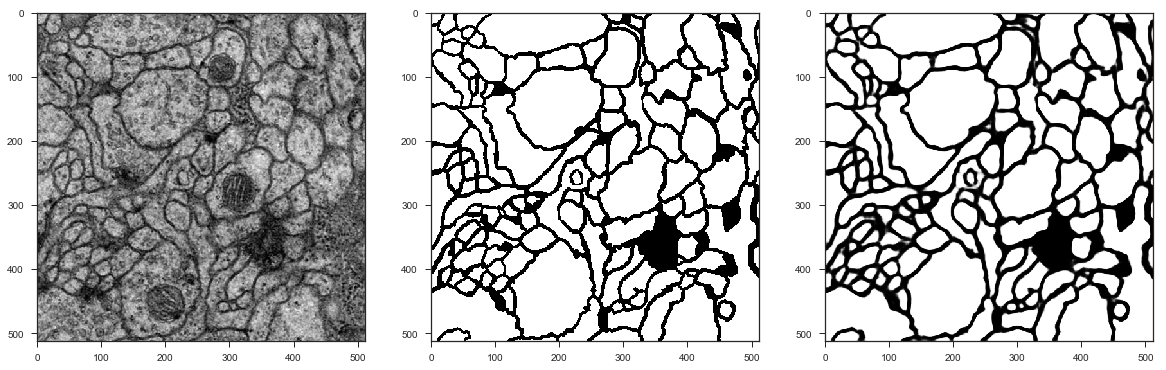

In [18]:
y_pred = model_unet_side_fuse.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

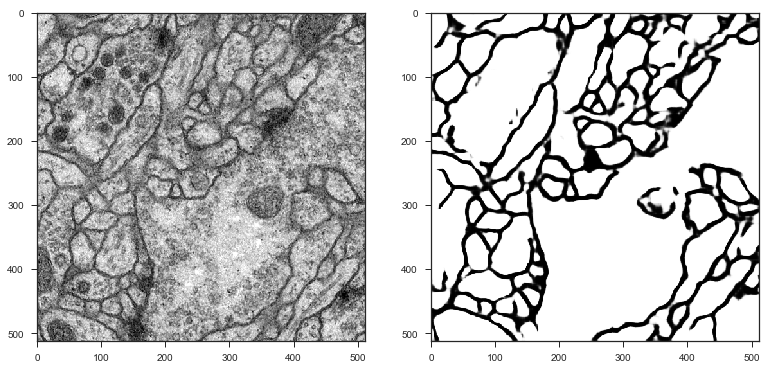

In [20]:
y_pred = model_unet_side_fuse.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [22]:
result = model_unet_side_fuse.predict(X_test)[-1]
result = result.astype(np.float32)
result.shape

(30, 512, 512, 1)

In [23]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Result_Tu_Lan_' + timestamp + '.tif', result, dtype=np.float32)

In [32]:
test_result = tiff.imread(RESULT_PATH + 'Result_Tu_Lan_20180509-162751.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

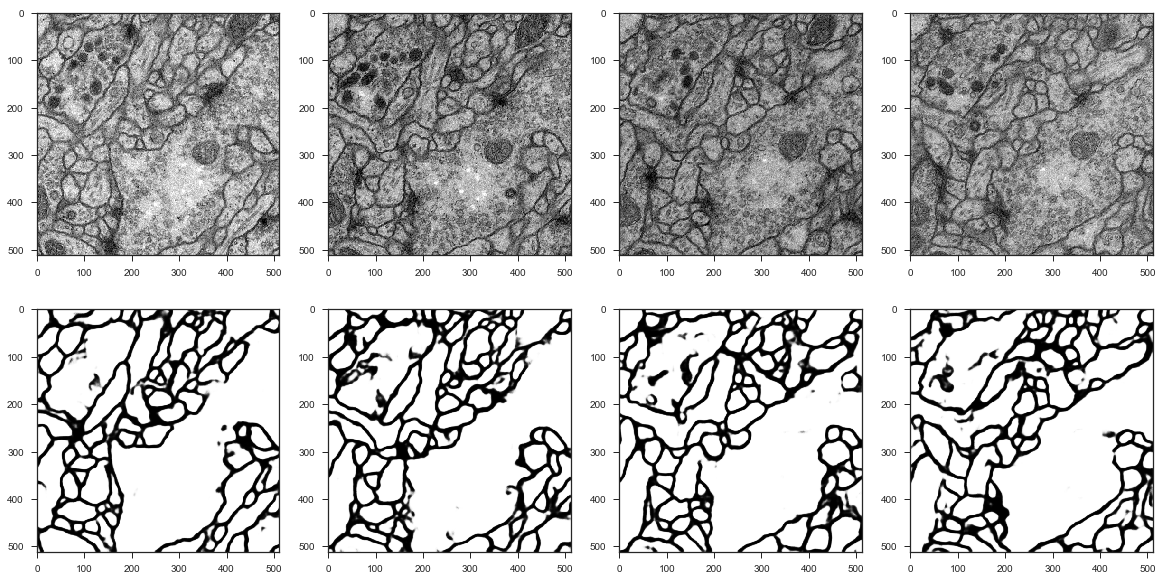

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()